In [3]:
import os
import torch
import torchvision.models as models
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from dataloader import CityscapesSkyDataset  # Ensure this is correct
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt 
from tqdm import tqdm
import numpy as np

# Loading the model 
model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=1)
model.load_state_dict(torch.load('../models/sky_segmentation_model_25_epochs.pth'))

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image_test_dir = os.path.join(os.getcwd(), '..', 'dataset', 'Cityscapes', 'leftImg8bit', 'test')
mask_test_dir = os.path.join(os.getcwd(), '..', 'dataset', 'Cityscapes', 'gtFine', 'test')

test_dataset = CityscapesSkyDataset(image_dir=image_test_dir, mask_dir=mask_test_dir, transform=transform, target_transform=target_transform)
rand_indices = torch.randperm(len(test_dataset)).tolist()

reduced_test_dataset = Subset(test_dataset, rand_indices[:100])
test_loader = DataLoader(reduced_test_dataset, batch_size=8, shuffle=False, num_workers=0)

model.eval()
progress_bar = tqdm(test_loader, desc='Testing')
running_loss = 0.0
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)
loss = torch.nn.BCEWithLogitsLoss()
loss.to(device)

images_list = []
masks_list = []
outputs_list = []

with torch.no_grad():
    for idx, (images, masks) in enumerate(progress_bar):
        # Moving images and masks to the same device as the model
        images = images.to(device)
        masks = masks.to(device)
        
        output = model(images)['out']
        loss_value = loss(output, masks)
        running_loss += loss_value.item()
        progress_bar.set_postfix({'Loss': loss_value.item()})

        # Applying sigmoid activation and thresholding
        output = torch.sigmoid(output)
        output = (output > 0.5).float()  # Converting probabilities to binary mask
        
        if idx < 5:  #  first 5 batches for visualization
            images_list.append(images.cpu())
            masks_list.append(masks.cpu())
            outputs_list.append(output.cpu())
    
print('Loss: ', running_loss / len(test_loader))

Testing: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s, Loss=0.199] 

Loss:  0.1259419912329087


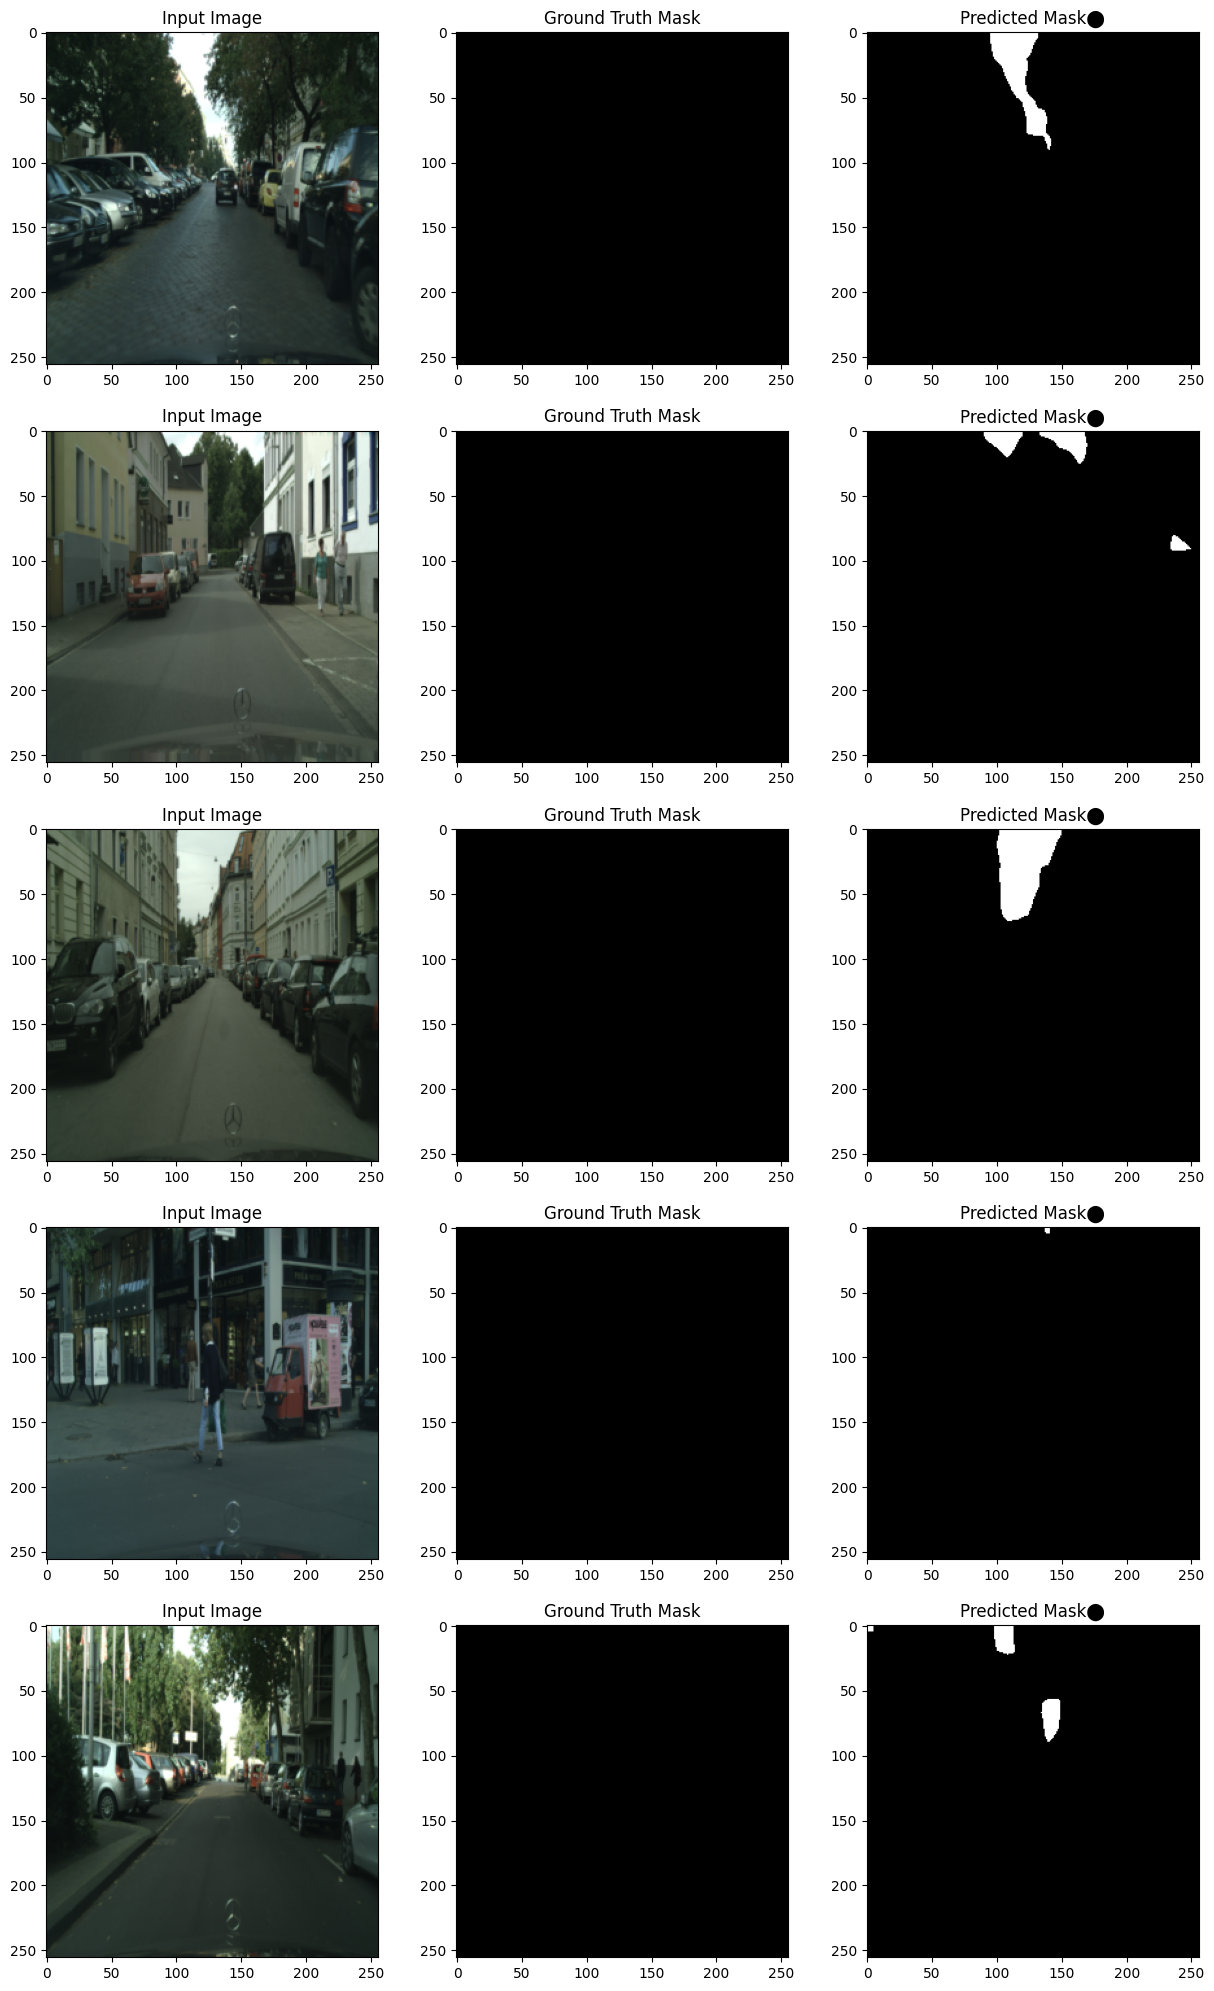

In [10]:

# Visualization
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    for j in range(images_list[i].size(0)):  # Loop over batch size
        denormalized_image = images_list[i][j].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        denormalized_image = denormalized_image.numpy().clip(0, 1)  # Clip values to the [0, 1] range
        ax[i, 0].imshow(denormalized_image)
        ax[i, 0].set_title('Input Image')
        mask = masks_list[i][j].squeeze() * 255
        ax[i, 1].imshow(mask.numpy(), cmap='gray')
        ax[i, 1].set_title('Ground Truth Mask')
        ax[i, 2].imshow(outputs_list[i][j].squeeze().numpy(), cmap='gray')
        ax[i, 2].set_title('Predicted Mask​⬤')

## Conversion of model to ONNX format

In [11]:
import torch
import torchvision.models as models
import time

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 256, 256)
dummy_input = dummy_input.to(device)
# Export the model to ONNX format with opset version 12
print("Starting conversion with opset version 12...")
start_time = time.time()

try:
    torch.onnx.export(model, dummy_input, "sky_segmentation_model_25_epochs.onnx", opset_version=12)
    end_time = time.time()
    print(f"ResNet-101 model successfully converted to ONNX format with opset version 12 in {end_time - start_time} seconds.")
except Exception as e:
    end_time = time.time()
    print(f"An error occurred during export: {e}")
    print(f"Time taken: {end_time - start_time} seconds.")

Starting conversion with opset version 12...
ResNet-101 model successfully converted to ONNX format with opset version 12 in 8.578757047653198 seconds.


## Test of model on extra test images

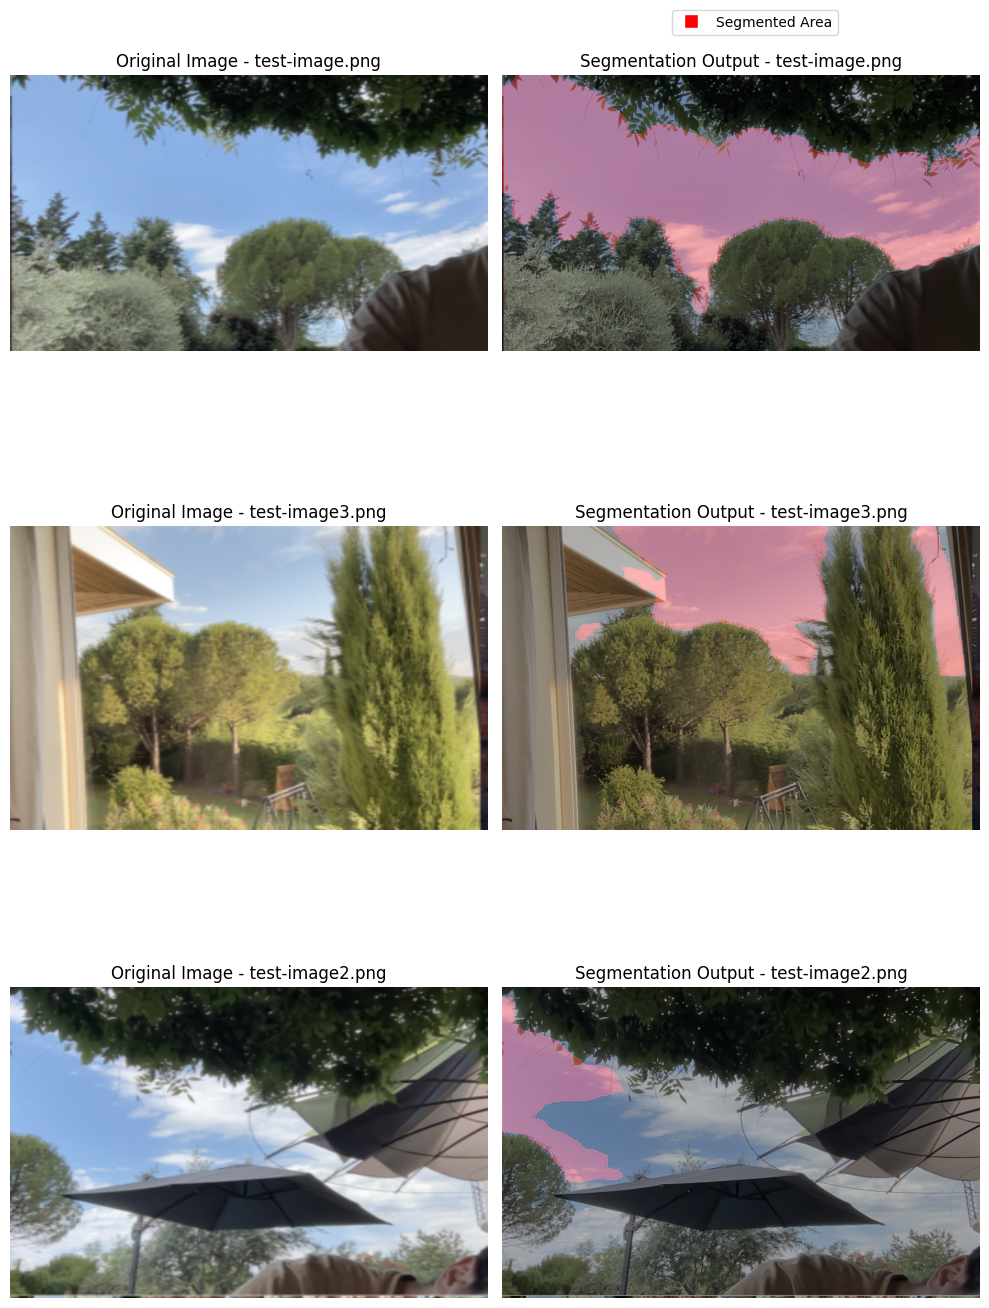

In [16]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function to denormalize images
def denormalize(image):
    device = image.device
    return image * torch.tensor([0.229, 0.224, 0.225], device=device) + torch.tensor([0.485, 0.456, 0.406], device=device)

# Load test images
extra_test_images_path = os.path.join(os.getcwd(), '..', 'dataset', 'extra_test_images')
extra_test_images = os.listdir(extra_test_images_path)

# Create a figure for the grid
fig, axes = plt.subplots(len(extra_test_images), 2, figsize=(10, len(extra_test_images) * 5))

for idx, image_name in enumerate(extra_test_images):
    image_path = os.path.join(extra_test_images_path, image_name)
    image = Image.open(image_path)
    original_size = image.size  # Save the original size
    input_image = transform(image.convert('RGB')).unsqueeze(0).to(device)
    
    # Display the original image
    denormalized_image = denormalize(input_image.squeeze().permute(1, 2, 0)).cpu().numpy().clip(0, 1)
    denormalized_image = cv2.resize(denormalized_image, original_size)
    axes[idx, 0].imshow(denormalized_image)
    axes[idx, 0].set_title(f'Original Image - {image_name}')
    axes[idx, 0].axis('off')
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)['out']
        output = torch.sigmoid(output)
        output = (output > 0.5).float()
    
    # Convert the output to a numpy array
    output = output.squeeze().cpu().numpy()
    
    # Convert the output to a binary mask
    binary_mask = (output * 255).astype(np.uint8)
    
    # Resize the output to the original image size
    binary_mask = cv2.resize(binary_mask, original_size)
    
    # Create an outline of the segmented areas
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outline_mask = np.zeros_like(binary_mask)
    cv2.drawContours(outline_mask, contours, -1, 255, thickness=2)
    
    # Create a red mask where the segmented areas are highlighted in red
    red_mask = np.zeros_like(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR))
    red_mask[:, :, 2] = binary_mask
    red_outline_mask = np.zeros_like(red_mask)
    red_outline_mask[:, :, 2] = outline_mask
    
    overlay = cv2.addWeighted(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), 0.7, red_mask, 0.3, 0)
    overlay = cv2.addWeighted(overlay, 1, red_outline_mask, 1, 0)
    
    # Convert back to RGB for matplotlib
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    # Display the output mask
    axes[idx, 1].imshow(overlay)
    axes[idx, 1].set_title(f'Segmentation Output - {image_name}')
    axes[idx, 1].axis('off')

# Adjust layout and add legend
handles = [plt.Line2D([0], [0], color='w', markerfacecolor='r', marker='s', markersize=10, label='Segmented Area')]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.85, 0.95))
plt.tight_layout()
plt.show()